In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/OMF_data_final/uploaded_data_2/Dataset_2_csv.csv')
df = df[df.columns[1:]]
df = df.iloc[::-1]

In [ ]:
window = 30
num_days = len(df.index)
num_companies = df.columns.size
total_rows = num_days - window # Modified(decreased by 1) as we are checking with actual returns

In [ ]:
prices = df.to_numpy()

In [ ]:
true_price_relative = prices[1:]/prices[:-1]

In [ ]:
def rpr_predict_next_relative(given_price, theta = 0.8):
  n = len(given_price)
  prev_pred = given_price[1]/given_price[0]
  prev_rel = given_price[1]/given_price[0]

  for i in range(1,n):
    prev_rel = given_price[i]/given_price[i-1]
    gamma = theta*prev_rel/(theta*prev_rel + prev_pred)
    pred = gamma + (1 - gamma)*(prev_pred/prev_rel)
    prev_pred = pred*1

  return prev_pred

In [ ]:
# def simplex_proj(y):
#     """Projection of y onto simplex."""
#     m = len(y)
#     bget = False

#     s = sorted(y, reverse=True)
#     tmpsum = 0.0

#     for ii in range(m - 1):
#         tmpsum = tmpsum + s[ii]
#         tmax = (tmpsum - 1) / (ii + 1)
#         if tmax >= s[ii + 1]:
#             bget = True
#             break

#     if not bget:
#         tmax = (tmpsum + s[m - 1] - 1) / m

#     return np.maximum(y - tmax, 0.0)

In [ ]:
def simplex_proj(y):
    """Projection of y onto simplex."""
    m = len(y)

    s = sorted(y, reverse=True)
    tmpsum = 0.0
    p = 0

    for ii in range(m):
        tmpsum = tmpsum + s[ii]
        tmax = (tmpsum - 1) / (ii + 1)
        if s[ii] - tmax > 0:
            p = ii + 1

    reqsum = 0
    for ii in range(p):
      reqsum += s[ii]

    theta = 0
    if p==0:
      print('p = 0')
      theta = (tmpsum - 1)/m
    else:
      theta = (reqsum - 1)/p

    return np.maximum(y - theta, 0.0)

In [ ]:
def get_distribution(b, given_price, eps = 50, theta = 0.8):
        phi_pred = rpr_predict_next_relative(given_price,theta)
        # Calculate variables
        phi_pred_mean = np.mean(phi_pred)

        if np.linalg.norm(phi_pred - phi_pred_mean) ** 2 == 0:
            lam = 0
        else:
            lam = max(0.0,(eps - np.dot(b, phi_pred))/ np.linalg.norm(phi_pred - phi_pred_mean) ** 2)

        x_sma = given_price.mean()/given_price[-1]
        D_pred = np.diag(np.array(x_sma))

        # update portfolio
        if lam != 0: # avoid numerical problem (0 * inf)
            b_ = b + lam * np.dot(D_pred, (phi_pred - phi_pred_mean))
        else:
            b_ = b

        b_ = np.clip(b_, -1e10, 1e10) # avoid numerical problem

        # project it onto simplex
        # return b_
        return simplex_proj(y=b_)

In [ ]:
# total_rows = 1
max_num_matches = 0
min_num_matches = num_companies
for i in range(total_rows):
  temp_price_df = df[i:i+window]
  actual_next_price_df = df.iloc[i+window]

  given_price = temp_price_df.to_numpy()
  actual_next_price = actual_next_price_df.to_numpy()

  phi_pred = rpr_predict_next_relative(given_price)
  # print(phi_pred)
  check = actual_next_price/given_price[-1]
  # print(actual_next_price/given_price[-1])
  cnt = 0
  for j in range(len(phi_pred)):
    if phi_pred[j] >= 1 and check[j]>=1:
      cnt += 1
    elif phi_pred[j] <= 1 and check[j]<=1:
      cnt += 1
  # print(cnt)
  max_num_matches = max(max_num_matches,cnt)
  min_num_matches = min(min_num_matches,cnt)
print("Max matches : ",max_num_matches,"\nMin matches : ",min_num_matches)

Max matches :  46 
Min matches :  9


In [ ]:
weights = []

In [ ]:
import random
prev_weights = []
for itr in range(total_rows):
  # Selecting random initial weights
  pw = []
  for _ in range(num_companies):
    pw.append(random.random())
  temp_tot = sum(pw)
  for i in range(num_companies):
    pw[i] /= temp_tot
  prev_weights.append(pw)

In [ ]:
# prev_b = np.array([1/num_companies]*num_companies)
for i in range(total_rows):
  prev_b = prev_weights[i]
  temp_price_df = df[i:i+window]
  actual_next_price_df = df.iloc[i+window]

  given_price = temp_price_df.to_numpy()
  actual_next_price = actual_next_price_df.to_numpy()

  phi_pred = rpr_predict_next_relative(given_price)
  w = get_distribution(prev_b,given_price)
  weights.append(w)
  # prev_b = w

In [ ]:
print(weights)

[array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0

In [ ]:
for i in range(len(weights)):
  print(i,':')
  for j in range(num_companies):
    if (weights[i][j]>1e-3):
      print('Stock ',j)

0 :
Stock  0
1 :
Stock  0
2 :
Stock  0
3 :
Stock  27
4 :
Stock  26
5 :
Stock  26
6 :
Stock  3
7 :
Stock  3
8 :
Stock  3
9 :
Stock  3
10 :
Stock  38
11 :
Stock  37
12 :
Stock  27
13 :
Stock  3
14 :
Stock  26
15 :
Stock  27
16 :
Stock  27
17 :
Stock  27
18 :
Stock  7
19 :
Stock  43
20 :
Stock  43
21 :
Stock  37
22 :
Stock  43
23 :
Stock  43
24 :
Stock  43
25 :
Stock  22
26 :
Stock  22
27 :
Stock  27
28 :
Stock  22
29 :
Stock  3
30 :
Stock  3
31 :
Stock  3
32 :
Stock  43
33 :
Stock  27
34 :
Stock  36
35 :
Stock  27
36 :
Stock  22
37 :
Stock  22
38 :
Stock  43
39 :
Stock  42
40 :
Stock  38
41 :
Stock  17
42 :
Stock  27
43 :
Stock  43
44 :
Stock  27
45 :
Stock  43
46 :
Stock  27
47 :
Stock  6
48 :
Stock  27
49 :
Stock  22
50 :
Stock  3
51 :
Stock  38
52 :
Stock  27
53 :
Stock  27
54 :
Stock  27
55 :
Stock  46
56 :
Stock  37
57 :
Stock  38
Stock  46
58 :
Stock  38
59 :
Stock  42
60 :
Stock  40
61 :
Stock  22
62 :
Stock  22
63 :
Stock  43
64 :
Stock  22
65 :
Stock  22
66 :
Stock  4
67 :
Stock

## Checking Actual Returns

In [ ]:
prices = df.to_numpy()

In [ ]:
return_rate = (prices[1:] - prices[:-1])/prices[:-1]

In [ ]:
weights = weights[:-1]

In [ ]:
weights = np.array(weights)

In [ ]:
return_at_weight = []

In [ ]:
day = []

In [ ]:
for i in range(window, total_rows):
  r = weights[i-window]@return_rate[i]
  return_at_weight.append(r)
  day.append(i-window+1)

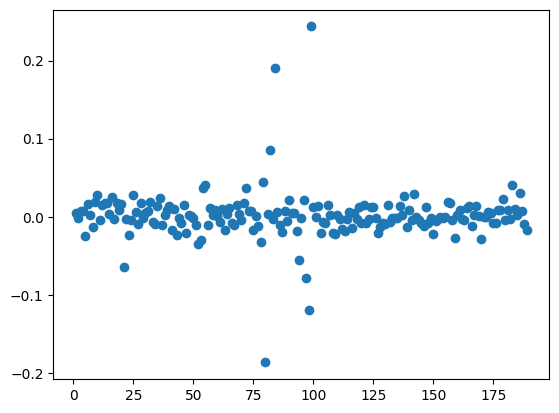

In [ ]:
plt.plot(day,return_at_weight,'o')
plt.show()

In [ ]:
print(sum(return_at_weight))

0.30758192069231444


In [ ]:
# def remove_outliers(data, threshold=3):
#     z_scores = np.abs((data - np.mean(data)) / np.std(data))
#     return [x for x, z in zip(data, z_scores) if z <= threshold]

In [ ]:
# return_update = remove_outliers(return_at_weight)

In [ ]:
# print(sum(return_update)/len(return_update))

Checking Sharpe Ratios

In [ ]:
sharpe_at_weight = []

In [ ]:
for i in range(window, total_rows):
  temp_price_df = df[i:i+window]
  temparr = temp_price_df.to_numpy()
  temp_return_rate = (temparr[:-1] - temparr[1:])/temparr[1:]
  cov = np.cov(np.transpose(temp_return_rate))

  # print(weights.shape)

  s = (weights[i-window]@return_rate[i])/math.sqrt((weights[i-window]@cov@weights[i-window]))
  sharpe_at_weight.append(s)

In [ ]:
print(sum(sharpe_at_weight))

12.748714499352335


Comparison with Sharpe using DLFP

In [ ]:
sharpe_dlfp_rpr = []

In [ ]:
w_rpr_df = pd.read_csv('/content/drive/MyDrive/Weights without transaction cost/Weights with rpr return')
w_rpr_df = w_rpr_df[:-1]
w_rpr_df = w_rpr_df.iloc[:,1:]
w_rpr = w_rpr_df.to_numpy()

In [ ]:
for i in range(window, total_rows):
  temp_price_df = df[i:i+window]
  temparr = temp_price_df.to_numpy()
  temp_return_rate = (temparr[:-1] - temparr[1:])/temparr[1:]
  cov = np.cov(np.transpose(temp_return_rate))

  s = w_rpr[i-window]@return_rate[i]/math.sqrt((w_rpr[i-window]@cov@w_rpr[i-window]))
  sharpe_dlfp_rpr.append(s)

In [ ]:
print(sum(sharpe_dlfp_rpr))

16.201353513120036


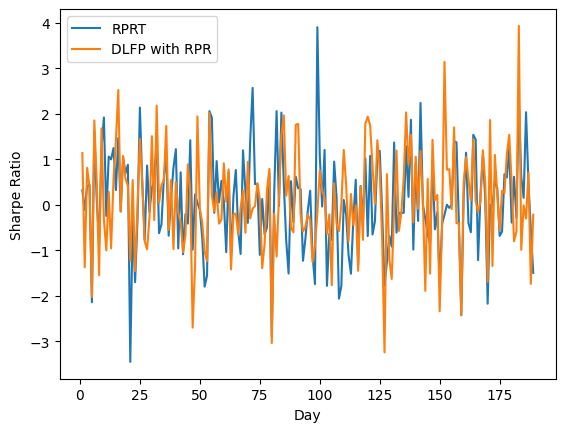

In [ ]:
plt.plot(day,sharpe_at_weight,label='RPRT')
plt.plot(day,sharpe_dlfp_rpr,label='DLFP with RPR')
plt.xlabel('Day')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.show()

Shapre using 0.23

In [ ]:
sharpe_0_23 = []

In [ ]:
w_0_23_df = pd.read_csv('/content/drive/MyDrive/Weights without transaction cost/Weights with 0_23 beta')
w_0_23_df = w_0_23_df[:-1]
w_0_23_df = w_0_23_df.iloc[:,1:]
w_0_23 = w_0_23_df.to_numpy()

In [ ]:
for i in range(window, total_rows):
  temp_price_df = df[i:i+window]
  temparr = temp_price_df.to_numpy()
  temp_return_rate = (temparr[:-1] - temparr[1:])/temparr[1:]
  cov = np.cov(np.transpose(temp_return_rate))

  s = w_0_23[i-window]@return_rate[i]/math.sqrt((w_0_23[i-window]@cov@w_0_23[i-window]))
  sharpe_0_23.append(s)

In [ ]:
print(sum(sharpe_0_23))

27.115537485034977


Sharpe using OG

In [ ]:
sharpe_og = []

In [ ]:
w_og_df = pd.read_csv('/content/drive/MyDrive/Weights without transaction cost/Weights with normal average')
w_og_df = w_og_df[:-1]
w_og_df = w_og_df.iloc[:,1:]
w_og = w_og_df.to_numpy()

In [ ]:
for i in range(window, total_rows):
  temp_price_df = df[i:i+window]
  temparr = temp_price_df.to_numpy()
  temp_return_rate = (temparr[:-1] - temparr[1:])/temparr[1:]
  cov = np.cov(np.transpose(temp_return_rate))

  s = w_og[i-window]@return_rate[i]/math.sqrt((w_og[i-window]@cov@w_og[i-window]))
  sharpe_og.append(s)

In [ ]:
print(sum(sharpe_og))

20.339403126533423


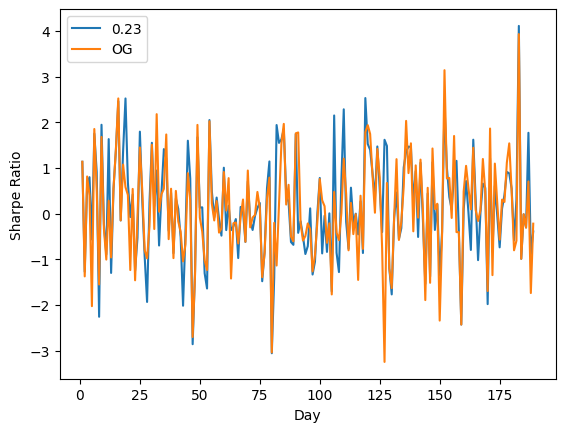

In [ ]:
plt.plot(day,sharpe_0_23,label='0.23')
plt.plot(day,sharpe_dlfp_rpr,label='OG')
plt.xlabel('Day')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.show()